# Introducción a la Ciencia de Datos: Tarea 2

Este notebook contiene el código de base para realizar la Tarea 2 del curso. Puede copiarlo en su propio repositorio y trabajar sobre el mismo.
Las **instrucciones para ejecutar el notebook** están en la [página inicial del repositorio](https://gitlab.fing.edu.uy/maestria-cdaa/intro-cd/).

**Se espera que no sea necesario revisar el código para corregir la tarea**, ya que todos los resultados y análisis relevantes deberían estar en el **informe en formato PDF**.

## Cargar dependencias
Para esta tarea, se han agregado algunos requerimientos, asegúrese de instalarlos (puede usar el mismo entorno virtual de la Tarea 1):

In [73]:
!pip install jupyter pandas "sqlalchemy<2.0" pymysql seaborn pillow scikit-learn


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [74]:
from time import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

## Conexión a la Base y Lectura de Datos

In [75]:
# DataFrame con todas las obras:
df_works = pd.read_csv('./data/shakespeare/works.csv')

# Todos los párrafos de todas las obras
df_paragraphs = pd.read_csv('./data/shakespeare/paragraphs.csv')

# TODO: cargar el resto de las tablas
df_chapters = pd.read_csv('./data/shakespeare/chapters.csv')
df_characters = pd.read_csv('./data/shakespeare/characters.csv')

In [59]:
df_paragraphs

,Unnamed: 0,id,ParagraphNum,PlainText,character_id,chapter_id
0,0,630863,3,"[Enter DUKE ORSINO, CURIO, and other Lords; Mu...",1261,18704
1,1,630864,4,"If music be the food of love, play on;\r\nGive...",840,18704
2,2,630865,19,"Will you go hunt, my lord?",297,18704
3,3,630866,20,"What, Curio?",840,18704
4,4,630867,21,The hart.,297,18704
...,...,...,...,...,...,...
35460,35460,666323,3460,"That she is living,\r\nWere it but told you, s...",866,19648
35461,35461,666324,3467,"You gods, look down\r\nAnd from your sacred vi...",584,19648
35462,35462,666325,3475,There's time enough for that;\r\nLest they des...,866,19648
35463,35463,666326,3483,"O, peace, Paulina!\r\nThou shouldst a husband ...",667,19648


## Limpieza de Texto

In [76]:
# TODO: Actualizar con su versión de clean_text() de la Tarea_1

def clean_text(df, column_name):
    # Convertir todo a minúsculas
    result = df[column_name].str.lower()

    # Quitar signos de puntuación y cambiarlos por espacios (" ")
    # TODO: completar signos de puntuación faltantes
    for punc in ["[", "]", "\n", "\r", ",", ";", "?", ".", "!", ":", "'", "-", "_", "(", ")", "&", '"', "0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]:
        result = result.str.replace(punc, " ")
    return result

# Creamos una nueva columna CleanText a partir de PlainText
df_paragraphs["CleanText"] = clean_text(df_paragraphs, "PlainText")

# Veamos la diferencia
df_paragraphs[["PlainText", "CleanText"]]

,PlainText,CleanText
0,"[Enter DUKE ORSINO, CURIO, and other Lords; Mu...",enter duke orsino curio and other lords mu...
1,"If music be the food of love, play on;\r\nGive...",if music be the food of love play on give m...
2,"Will you go hunt, my lord?",will you go hunt my lord
3,"What, Curio?",what curio
4,The hart.,the hart
...,...,...
35460,"That she is living,\r\nWere it but told you, s...",that she is living were it but told you sho...
35461,"You gods, look down\r\nAnd from your sacred vi...",you gods look down and from your sacred vial...
35462,There's time enough for that;\r\nLest they des...,there s time enough for that lest they desir...
35463,"O, peace, Paulina!\r\nThou shouldst a husband ...",o peace paulina thou shouldst a husband ta...


In [77]:
# Agregamos personajes, obras y géneros en el mismo dataset
df_dataset = df_paragraphs.merge(df_chapters.set_index("id")["work_id"], left_on="chapter_id", right_index=True)
df_dataset = df_dataset.merge(df_works.set_index("id")[["Title", "GenreType"]], left_on="work_id", right_index=True)
df_dataset = df_dataset.merge(df_characters.set_index('id')["CharName"], left_on="character_id", right_index=True).sort_index()
df_dataset = df_dataset[["CleanText", "CharName", "Title", "GenreType"]]

# Usaremos sólo estos personajes
characters = ["Antony", "Cleopatra", "Queen Margaret"]
df_dataset = df_dataset[df_dataset["CharName"].isin(characters)]

df_dataset

,CleanText,CharName,Title,GenreType
2058,if it be love indeed tell me how much,Cleopatra,Antony and Cleopatra,Tragedy
2059,there s beggary in the love that can be reckon d,Antony,Antony and Cleopatra,Tragedy
2060,i ll set a bourn how far to be beloved,Cleopatra,Antony and Cleopatra,Tragedy
2061,then must thou needs find out new heaven new ...,Antony,Antony and Cleopatra,Tragedy
2064,grates me the sum,Antony,Antony and Cleopatra,Tragedy
...,...,...,...,...
27583,thou hadst a clarence too and richard kill d ...,Queen Margaret,Richard III,History
27585,bear with me i am hungry for revenge and no...,Queen Margaret,Richard III,History
27587,i call d thee then vain flourish of my fortune...,Queen Margaret,Richard III,History
27589,forbear to sleep the nights and fast the days...,Queen Margaret,Richard III,History


In [78]:
# Párrafos por cada personaje seleccionado
df_dataset["CharName"].value_counts()

CharName
Antony            253
Cleopatra         204
Queen Margaret    169
Name: count, dtype: int64

## Dataset y Features de texto

In [79]:
X = df_dataset["CleanText"].to_numpy()
y = df_dataset["CharName"].to_numpy()

In [80]:
# TODO: Partir train/test 30% estratificados

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

print(f"Tamaños de Train/Test: {len(X_train)}/{len(X_test)}")

Tamaños de Train/Test: 438/188


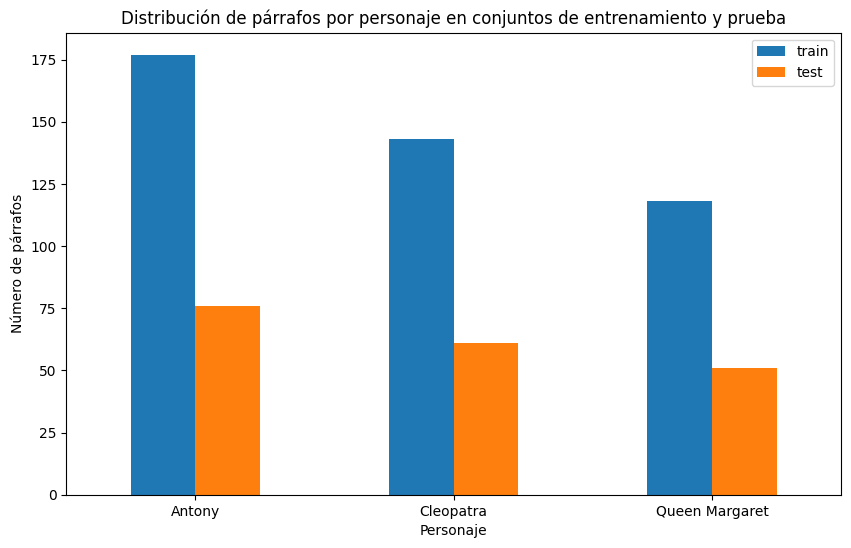

train      test     
26.940639  27.127660    1
32.648402  32.446809    1
40.410959  40.425532    1
Name: count, dtype: int64

In [81]:
# Visualización para verificar el balance de párrafos
# Quiero asegurar que y_train y y_test sean Series
y_train = pd.Series(y_train)
y_test = pd.Series(y_test)

# Contar el número de párrafos por personaje en los conjuntos de entrenamiento y prueba
train_counts = y_train.value_counts()
test_counts = y_test.value_counts()

# DataFrame para facilitar la visualización
counts_df = pd.DataFrame({'train': train_counts, 'test': test_counts}).sort_index()

# Visualización
counts_df.plot(kind='bar', figsize=(10, 6))
plt.title('Distribución de párrafos por personaje en conjuntos de entrenamiento y prueba')
plt.xlabel('Personaje')
plt.ylabel('Número de párrafos')
plt.xticks(rotation=0)

# Guardar la figura antes de mostrarla
plt.savefig('./Parte_1/Fig/distribucion_personajes.png')

plt.show()

# Ahora vemos los porcentajes de cada uno en una tabla 
# Calcular los porcentajes
train_percentages = (train_counts / train_counts.sum()) * 100
test_percentages = (test_counts / test_counts.sum()) * 100

# Crear un DataFrame para porcentages
percentages_df = pd.DataFrame({'train': train_percentages, 'test': test_percentages}).sort_index()

percentages_df.value_counts()


### Conteo de palabras y TF-IDF

In [82]:
# Representación del texto de forma numérica 
count_vect = CountVectorizer(stop_words=None, ngram_range=(1,1))
X_train_counts = count_vect.fit_transform(X_train)

# Obtener el tamaño de la matriz
size = X_train_counts.shape
print("Tamaño de la matriz X_train_counts:", size)

# Ejemplo de textos
texts = [
    "El lugar es mágico",
    "El lugar es raro",
    "Un día lo soñé"
]

# Inicializar el CountVectorizer
vectorizer = CountVectorizer()

# Ajustar y transformar los textos
X_train_counts_ej = vectorizer.fit_transform(texts)

# Convertir a DataFrame para visualizar mejor
df_counts = pd.DataFrame(X_train_counts_ej.toarray(), columns=vectorizer.get_feature_names_out())
print(df_counts)

# Visualizar detalles
print("Vocabulario:", vectorizer.vocabulary_)
print("Tamaño de la matriz resultante:", X_train_counts_ej.shape)
print("Matriz de conteo de palabras (BoW):\n", df_counts)

# Ejemplo de cómo se vería la matriz dispersa
print("Matriz dispersa:\n", X_train_counts_ej)

Tamaño de la matriz X_train_counts: (438, 2807)
   día  el  es  lo  lugar  mágico  raro  soñé  un
0    0   1   1   0      1       1     0     0   0
1    0   1   1   0      1       0     1     0   0
2    1   0   0   1      0       0     0     1   1
Vocabulario: {'el': 1, 'lugar': 4, 'es': 2, 'mágico': 5, 'raro': 6, 'un': 8, 'día': 0, 'lo': 3, 'soñé': 7}
Tamaño de la matriz resultante: (3, 9)
Matriz de conteo de palabras (BoW):
    día  el  es  lo  lugar  mágico  raro  soñé  un
0    0   1   1   0      1       1     0     0   0
1    0   1   1   0      1       0     1     0   0
2    1   0   0   1      0       0     0     1   1
Matriz dispersa:
 <Compressed Sparse Row sparse matrix of dtype 'int64'
	with 12 stored elements and shape (3, 9)>
  Coords	Values
  (0, 1)	1
  (0, 4)	1
  (0, 2)	1
  (0, 5)	1
  (1, 1)	1
  (1, 4)	1
  (1, 2)	1
  (1, 6)	1
  (2, 8)	1
  (2, 0)	1
  (2, 3)	1
  (2, 7)	1


In [90]:
# Inicio el TfidfTransformer sin usar IDF
tf_idf = TfidfTransformer(use_idf=False)

# Ajustar y transformar la matriz de conteo de palabras
X_train_tf = tf_idf.fit_transform(X_train_counts)

# Mostrar la matriz resultante
#print(X_train_tf)

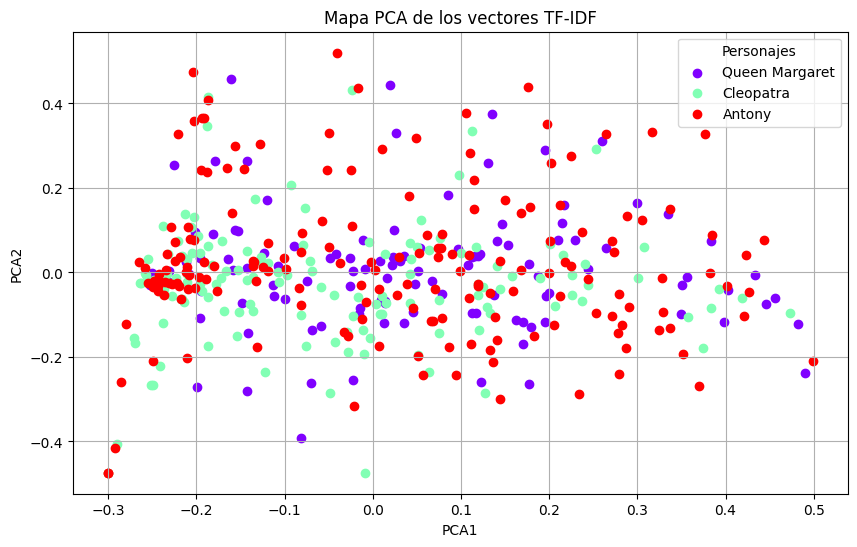

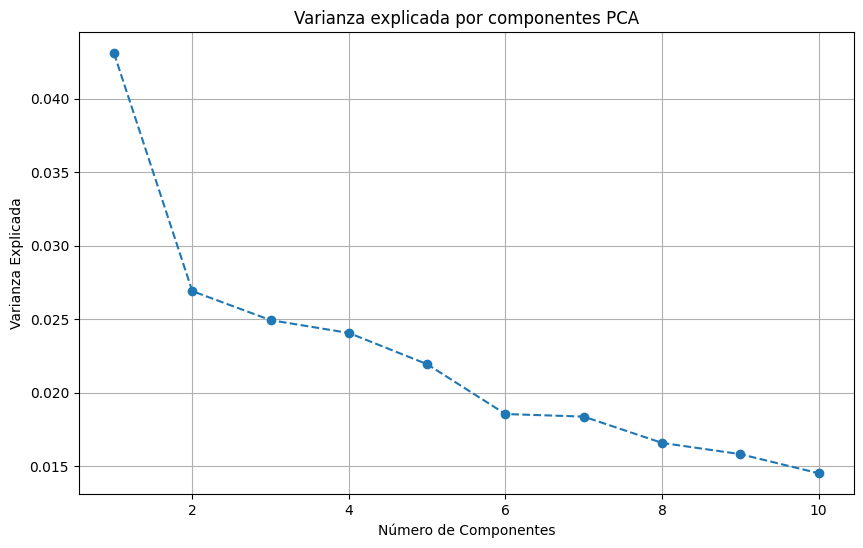

In [99]:
# Se realiza PCA sobre los datos de entrenamiento sin filtrar por stopwords, sin usar idf y separando en unigramas
from sklearn.decomposition import PCA

# Se inicia el CountVectorizer
count_vect = CountVectorizer(stop_words=None, ngram_range=(1, 1))
X_train_counts = count_vect.fit_transform(X_train)

# Se inicia el TfidfTransformer sin usar IDF
tf_idf = TfidfTransformer(use_idf=False)
X_train_tf = tf_idf.fit_transform(X_train_counts)

# Aplico PCA para reducir a 2 componentes principales
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_tf.toarray())

# DataFrame para visualizar mejor
df_pca = pd.DataFrame(X_train_pca, columns=['PCA1', 'PCA2'])
df_pca['Personaje'] = y_train

# Graficar los resultados
plt.figure(figsize=(10, 6))

# Defino personajes y colores
unique_personajes = np.unique(y_train)
colors = ['purple', 'cyan', 'red']

for personaje, color in zip(unique_personajes, colors):
    subset = df_pca[df_pca['Personaje'] == personaje]
    plt.scatter(subset['PCA1'], subset['PCA2'], c=[color], label=personaje)

plt.title('Mapa PCA de los vectores TF-IDF')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Personajes')
plt.grid(True)
plt.savefig('./Parte_1/Fig/mapa_pca_none.png')
plt.show()

# Varianza con más componentes
pca_full = PCA(n_components=10)
pca_full.fit(X_train_tf.toarray())
explained_variance = pca_full.explained_variance_ratio_

# Graficar la varianza según componente
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), explained_variance, marker='o', linestyle='--')
plt.title('Varianza explicada por componentes PCA')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada')
plt.grid(True)
plt.savefig('./Parte_1/Fig/varianza_explicada_none.png')
plt.show()

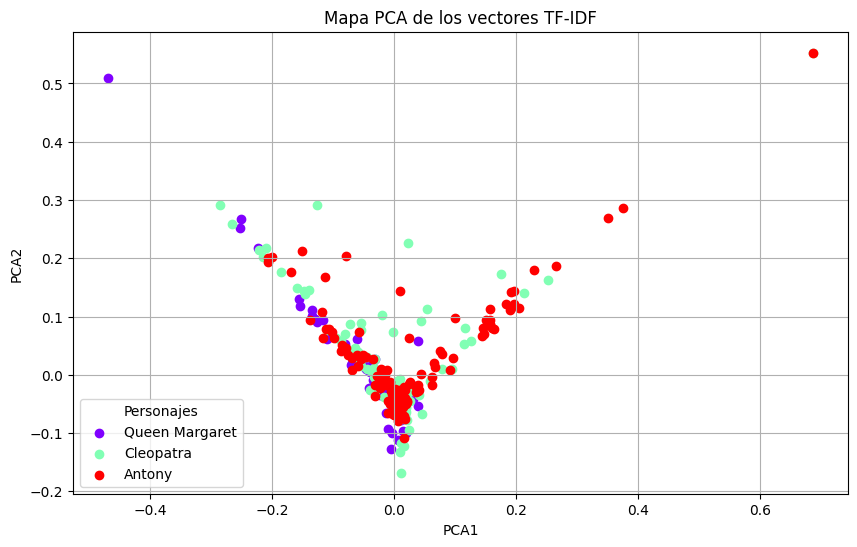

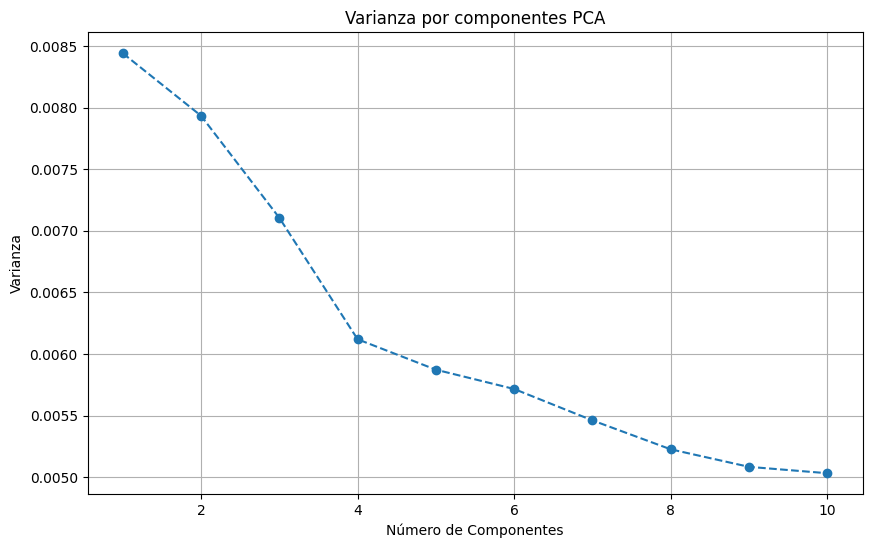

In [102]:
# Se realiza PCA sobre los datos de entrenamiento variando el filtrano las stopwords para inglés, tf-idf y n-grama
from sklearn.decomposition import PCA

# Se inicia el CountVectorizer
count_vect = CountVectorizer(stop_words='english', ngram_range=(1, 2))
X_train_counts = count_vect.fit_transform(X_train)

# Se inicia el TfidfTransformer sin usar IDF
tf_idf = TfidfTransformer(use_idf=True)
X_train_tf = tf_idf.fit_transform(X_train_counts)

# Aplico PCA para reducir a 2 componentes principales
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_tf.toarray())

# DataFrame para visualizar mejor
df_pca = pd.DataFrame(X_train_pca, columns=['PCA1', 'PCA2'])
df_pca['Personaje'] = y_train

# Graficar los resultados
plt.figure(figsize=(10, 6))



for personaje, color in zip(unique_personajes, colors):
    subset = df_pca[df_pca['Personaje'] == personaje]
    plt.scatter(subset['PCA1'], subset['PCA2'], c=[color], label=personaje)

plt.title('Mapa PCA de los vectores TF-IDF')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Personajes')
plt.grid(True)
plt.savefig('./Parte_1/Fig/mapa_pca_stopwords_idf_Bigrama.png')
plt.show()

# Varianza con más componentes
pca_full = PCA(n_components=10)
pca_full.fit(X_train_tf.toarray())
explained_variance = pca_full.explained_variance_ratio_

# Graficar la varianza según componente
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), explained_variance, marker='o', linestyle='--')
plt.title('Varianza por componentes PCA')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza')
plt.grid(True)
plt.savefig('./Parte_1/Fig/varianza_explicada_stopwords_idf_Bigrama.png')
plt.show()

### Reducción de dimensionalidad

## Modelos de Clasificación

In [103]:
# Se entrena el modelo con los datos filtrados por stopwords, agrupando por unigramas-bigramas y con idf en true
bayes_clf = MultinomialNB().fit(X_train_tf, y_train)

# Ver las primeras 10 predicciones de train
y_pred_train = bayes_clf.predict(X_train_tf)
y_pred_train[:10]

array(['Queen Margaret', 'Antony', 'Cleopatra', 'Antony', 'Cleopatra',
       'Cleopatra', 'Antony', 'Cleopatra', 'Antony', 'Antony'],
      dtype='<U14')

In [104]:
def get_accuracy(y_true, y_pred):
    return (y_true == y_pred).sum() / len(y_true)

get_accuracy(y_train, y_pred_train)

0.9634703196347032

Accuracy: 0.5745
Matriz de confusión:
[[69  6  1]
 [40 21  0]
 [30  3 18]]


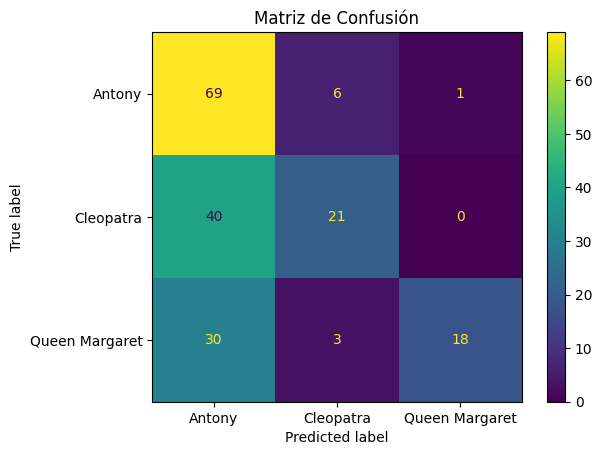

Precision por clase:
                Precision
Antony             0.4964
Cleopatra          0.7000
Queen Margaret     0.9474
Recall por clase:
                Recall
Antony          0.9079
Cleopatra       0.3443
Queen Margaret  0.3529


In [119]:
# TODO: Predecir para test y ver la matriz de confusión, y reportar accuracy

# Conjunto de test
X_test_counts = count_vect.transform(X_test)

X_test_tf = tf_idf.transform(X_test_counts)


# Predicciones sobre el conjunto de prueba
y_pred_test = bayes_clf.predict(X_test_tf)

# Calculo el accuracy
accuracy = get_accuracy(y_test, y_pred_test)
print(f'Accuracy: {accuracy:.4f}')

# Calculo la matriz de confusión
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)
print('Matriz de confusión:')
print(conf_matrix)

# Mostrar la matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
plt.title('Matriz de Confusión')
plt.savefig('./Parte_2/Fig/mat_confus.png')
plt.show()

# Se obtiene precision y recall para cada personaje
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
precision = precision_score(y_test, y_pred_test, average=None)
recall = recall_score(y_test, y_pred_test, average=None)

# Se asocia la precision y recall a cada personaje
personajes = sorted(set(y_train))  # Obtiene los nombres de los personajes en orden
precision_dict = {personaje: round(p, 4) for personaje, p in zip(personajes, precision)}
recall_dict = {personaje: round(r, 4) for personaje, r in zip(personajes, recall)}

print('Precision por clase:')
print(pd.DataFrame.from_dict(precision_dict, orient='index', columns=['Precision']))

print('Recall por clase:')
print(pd.DataFrame.from_dict(recall_dict, orient='index', columns=['Recall']))


### Búsqueda de hiper-parámetros con Cross-Validation

In [123]:
from sklearn.model_selection import StratifiedKFold

# Definición de los parámetros
param_sets = [{"stop_words": None, "ngram": (1, 2), "idf": False},
              {"stop_words": None, "ngram": (1, 1), "idf": False},
              {"stop_words": None, "ngram": (1, 2), "idf": True},
              {"stop_words": None, "ngram": (1, 1), "idf": True},
              {"stop_words": 'english', "ngram": (1,1), "idf": False},
              {"stop_words": 'english', "ngram": (1,2), "idf": False},
              {"stop_words": 'english', "ngram": (1,1), "idf": True},
              {"stop_words": 'english', "ngram": (1,2), "idf": True}]

skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# Renombrar para evitar confusión
X_dev = X_train
y_dev = y_train

for params in param_sets:
    # Transormaciones a aplicar (featurizers)
    count_vect = CountVectorizer(stop_words=params["stop_words"], ngram_range=params["ngram"])
    tf_idf = TfidfTransformer(use_idf=params["idf"])
    
    for train_idxs, val_idxs in skf.split(X_dev, y_dev):
        # Train y validation para el split actual
        X_train_ = [X_dev[i] for i in train_idxs]
        y_train_ = [y_dev[i] for i in train_idxs]
        X_val = [X_dev[i] for i in val_idxs]
        y_val = [y_dev[i] for i in val_idxs]
        
        # Ajustamos y transformamos Train
        X_train_counts = count_vect.fit_transform(X_train_)
        X_train_tf = tf_idf.fit_transform(X_train_counts)
        
        # Entrenamos con Train
        bayes_clf = MultinomialNB()
        bayes_clf.fit(X_train_tf, y_train_)
        
        # Transformamos Validation
        X_val_counts = count_vect.transform(X_val)
        X_val_tfidf = tf_idf.transform(X_val_counts)
        
        # Predecimos y evaluamos en Validation
        y_pred_val = bayes_clf.predict(X_val_tfidf)
        acc = get_accuracy(y_val, y_pred_val)
        print(f"{acc=:.4f} {params=}")


acc=0.4091 params={'stop_words': None, 'ngram': (1, 2), 'idf': False}
acc=0.4455 params={'stop_words': None, 'ngram': (1, 2), 'idf': False}
acc=0.4954 params={'stop_words': None, 'ngram': (1, 2), 'idf': False}
acc=0.4128 params={'stop_words': None, 'ngram': (1, 2), 'idf': False}
acc=0.4364 params={'stop_words': None, 'ngram': (1, 1), 'idf': False}
acc=0.4545 params={'stop_words': None, 'ngram': (1, 1), 'idf': False}
acc=0.4954 params={'stop_words': None, 'ngram': (1, 1), 'idf': False}
acc=0.4220 params={'stop_words': None, 'ngram': (1, 1), 'idf': False}
acc=0.4364 params={'stop_words': None, 'ngram': (1, 2), 'idf': True}
acc=0.4909 params={'stop_words': None, 'ngram': (1, 2), 'idf': True}
acc=0.5046 params={'stop_words': None, 'ngram': (1, 2), 'idf': True}
acc=0.4495 params={'stop_words': None, 'ngram': (1, 2), 'idf': True}
acc=0.4636 params={'stop_words': None, 'ngram': (1, 1), 'idf': True}
acc=0.5000 params={'stop_words': None, 'ngram': (1, 1), 'idf': True}
acc=0.5505 params={'stop_w

Accuracy: 0.5798
Matriz de confusión:
[[67  8  1]
 [40 21  0]
 [25  5 21]]


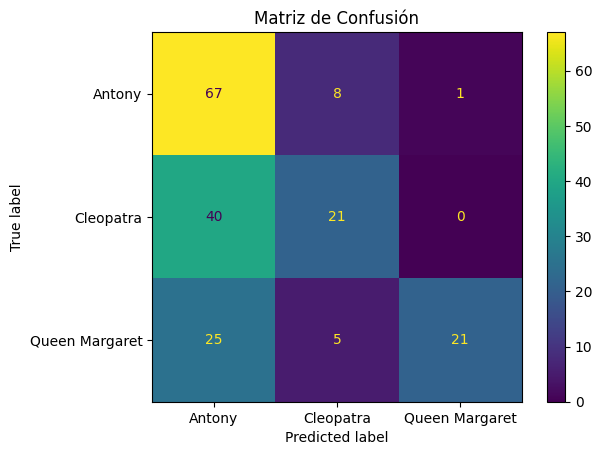

Precision por clase:
                Precision
Antony             0.5076
Cleopatra          0.6176
Queen Margaret     0.9545
Recall por clase:
                Recall
Antony          0.8816
Cleopatra       0.3443
Queen Margaret  0.4118


In [124]:
# ---- Modelo seleccionado con mejor accuracy ---- #

# Se inicia el CountVectorizer
count_vect = CountVectorizer(stop_words='english', ngram_range=(1, 1))
X_train_counts_model = count_vect.fit_transform(X_train)

# Se inicia el TfidfTransformer sin usar IDF
tf_idf = TfidfTransformer(use_idf=True)
X_train_tf_model = tf_idf.fit_transform(X_train_counts_model)

# Entrenamiento
bayes_clf = MultinomialNB().fit(X_train_tf_model, y_train)

# Conjunto de test
X_test_counts_model = count_vect.transform(X_test)

X_test_tf_model = tf_idf.transform(X_test_counts_model)


# Predicciones sobre el conjunto de prueba
y_pred_test_model = bayes_clf.predict(X_test_tf_model)

# Calculo el accuracy
accuracy_model = get_accuracy(y_test, y_pred_test_model)
print(f'Accuracy: {accuracy_model:.4f}')

# Calculo la matriz de confusión
from sklearn.metrics import confusion_matrix
conf_matrix_model = confusion_matrix(y_test, y_pred_test_model)
print('Matriz de confusión:')
print(conf_matrix_model)

# Mostrar la matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_model)
plt.title('Matriz de Confusión')
plt.savefig('./Parte_2/Fig/mat_confus_model.png')
plt.show()

# Se obtiene precision y recall para cada personaje
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
precision = precision_score(y_test, y_pred_test_model, average=None)
recall = recall_score(y_test, y_pred_test_model, average=None)

# Se asocia la precision y recall a cada personaje
personajes = sorted(set(y_train))  # Obtiene los nombres de los personajes en orden
precision_dict_model = {personaje: round(p, 4) for personaje, p in zip(personajes, precision)}
recall_dict_model = {personaje: round(r, 4) for personaje, r in zip(personajes, recall)}

print('Precision por clase:')
print(pd.DataFrame.from_dict(precision_dict_model, orient='index', columns=['Precision']))

print('Recall por clase:')
print(pd.DataFrame.from_dict(recall_dict_model, orient='index', columns=['Recall']))



In [125]:
### Entrenamiento y evaluación del modelo SVM

Accuracy SVM: 0.6543
Precision SVM por personaje:
Antony: 0.6040
Cleopatra: 0.5918
Queen Margaret: 0.8684
Recall SVM por personaje:
Antony: 0.8026
Cleopatra: 0.4754
Queen Margaret: 0.6471


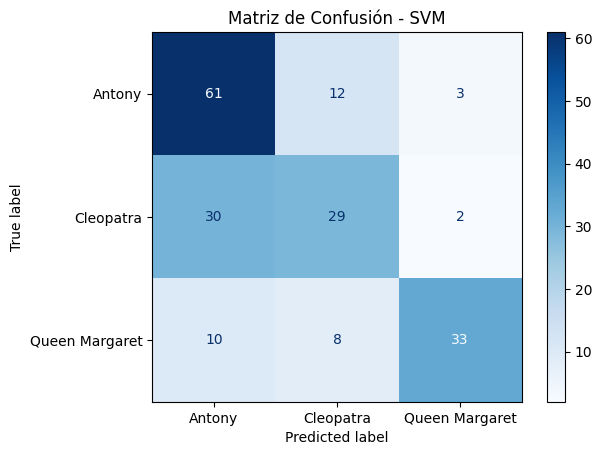

In [131]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

# Pipeline para SVM
svm_pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words='english', ngram_range=(1,1))),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('clf', SVC(kernel='linear', probability=True, random_state=42))
])

# Entrenamiento del modelo SVM
svm_pipeline.fit(X_train, y_train)

# Predicción del conjutno de test
y_pred_svm = svm_pipeline.predict(X_test)

# Métricas obtenid con SVM
accuracy_svm = get_accuracy(y_test, y_pred_svm)
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm, average=None)
recall_svm = recall_score(y_test, y_pred_svm, average=None)

# Etiquetas de los personajes
personajes = np.unique(y_train)

# Resultados con las etiquetas de los personajes
print(f"Accuracy SVM: {accuracy_svm:.4f}")
print("Precision SVM por personaje:")
for personaje, precision in zip(personajes, precision_svm):
    print(f"{personaje}: {precision:.4f}")

print("Recall SVM por personaje:")
for personaje, recall in zip(personajes, recall_svm):
    print(f"{personaje}: {recall:.4f}")

# Matriz de confusiónpara SVM
disp_svm = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_svm, display_labels=personajes)
disp_svm.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión - SVM')
plt.savefig('./Parte_2/Fig/mat_confus_SVM.png')
plt.show()

In [ ]:
# Comparación de SVM con MNB



### (Opcional) Comparativa con Fasttext

In [ ]:
!pip install fasttext

In [ ]:
import fasttext

y_train_s = np.char.replace(y_train.astype(str), " ", "_").astype(object)
y_test_s = np.char.replace(y_test.astype(str), " ", "_").astype(object)

# Convertimos al formato de fasttext: archivo de texto donde cada línea es:
# __label__<label> TEXTO
Xytrains = "__label__" + y_train_s.astype(object) + " " + X_train
Xytests = "__label__" + y_test_s.astype(object) + " " + X_test
np.savetxt(data_dir / "train.txt", Xytrains, fmt="%s")
np.savetxt(data_dir / "test.txt", Xytests, fmt="%s")

Xytests[0]

In [ ]:
model = fasttext.train_supervised(input=str(data_dir / "train.txt"), epoch=100, wordNgrams=2)
model.test(str(data_dir / "test.txt"))

In [ ]:
y_out = model.predict(list(X_test))
y_pred_test = [y[0].replace("__label__", "") for y in y_out[0]]
    
print(get_accuracy(y_test_s, y_pred_test))